In [1]:
import geopandas as gpd                # to read vector files (based on ogr)
import pandas as pd                    # to read .txt and manipulate data
from rasterstats import zonal_stats    # to do calculations on our rasters
import rasterio                        # To open and up .tif (Based on Gdal)
from rasterio.plot import show         # To visualise .tif opened up by rasterio (show(raster))

## Set paths to files and read them using geopandas (gpd) and rasterio

In [2]:
dsm = 'DSM_LondonCity_1m.tif'
shp = 'drone_pos_32631.gml'
drones = gpd.read_file(shp)
dsm_show = rasterio.open(dsm)

# print to check that the coordinate system for our files matches!
# If True, we are good to go.
drones.crs == dsm_show.crs 


C:\Users\xbacos\Anaconda3\envs\geo_py\lib\site-packages\geopandas\geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


True

#### Not sure what the warning actually mean. Others seems to have got this issue, but it does not seem to affect the preformance that much

In [3]:
# print to se what is inside drones. .head() prints out only 5 first rows. .tail() will print last 5

drones.head()

,fid,id,left,top,right,bottom,geometry
0,drone_pos.0,1,530866.4114,181947.5698,530966.4114,182047.5698,POINT (283895.042 5712398.431)
1,drone_pos.1,2,530866.4114,181847.5698,530966.4114,181947.5698,POINT (283888.211 5712298.629)
2,drone_pos.2,3,530866.4114,181747.5698,530966.4114,181847.5698,POINT (283881.380 5712198.826)
3,drone_pos.3,4,530866.4114,181647.5698,530966.4114,181747.5698,POINT (283874.549 5712099.024)
4,drone_pos.4,5,530866.4114,181547.5698,530966.4114,181647.5698,POINT (283867.718 5711999.221)


## Use .drop(columns=(' ') to remove columns we do not need

In [4]:
drones = drones.drop(columns=(['fid', 'left','top','right','bottom']))
drones.head()

,id,geometry
0,1,POINT (283895.042 5712398.431)
1,2,POINT (283888.211 5712298.629)
2,3,POINT (283881.380 5712198.826)
3,4,POINT (283874.549 5712099.024)
4,5,POINT (283867.718 5711999.221)


## use geopandas built-in function buffer to buffer around points. 

In [5]:
# Settings for buffer
style = 3 # 1 circle 3 square
radius = 100. # for float

# Buffer around points using 'geometry' colums. Call the new buffered geometry 'buff'
drones['buff'] = drones['geometry'].buffer(radius, cap_style=style)
drones.head()

,id,geometry,buff
0,1,POINT (283895.042 5712398.431),"POLYGON ((283995.042 5712498.431, 283995.042 5..."
1,2,POINT (283888.211 5712298.629),"POLYGON ((283988.211 5712398.629, 283988.211 5..."
2,3,POINT (283881.380 5712198.826),"POLYGON ((283981.380 5712298.826, 283981.380 5..."
3,4,POINT (283874.549 5712099.024),"POLYGON ((283974.549 5712199.024, 283974.549 5..."
4,5,POINT (283867.718 5711999.221),"POLYGON ((283967.718 5712099.221, 283967.718 5..."


## Visualise buffers on Dsm


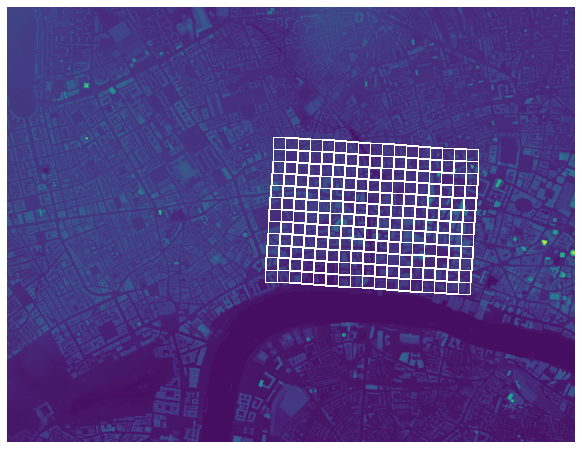

<AxesSubplot:>

In [6]:
drones['buff'].plot(facecolor = 'none' , edgecolor='white', figsize = (15,8)).axis('off')
show(dsm_show)


## Calculate zonal statistics for each buffer zone using rasterstats zonal_stats()

### Furter information on rasterstats https://pythonhosted.org/rasterstats/


In [13]:
# zonal_stats can calculate a lot of things. just chose the ones you want
# if stats is not specified as zonal_stats(shapefile, raster), count, min, max and mean is calculated  

# .loc[0] to select row index 0, in this case to not to have zonal_statistics printed for all rows

zonal_stats(drones.loc[0,'buff'],dsm, 
            stats = ['count', 'min', 'max', 'mean', 'sum', 'std', 'median', 
                     'majority', 'minority', 'unique', 'range', 'nodata', 'nan'])


[{'min': 18.15229034423828,
  'max': 51.697879791259766,
  'mean': 27.326821875,
  'count': 40000,
  'sum': 1093072.875,
  'std': 6.975544035922778,
  'median': 23.47443389892578,
  'majority': 22.260000228881836,
  'minority': 18.15229034423828,
  'unique': 21381,
  'range': 33.545589447021484,
  'nodata': 0.0,
  'nan': 0}]

## Join zonal_statistics to drone dataframe

In [14]:
# Create a new dataframe (drones_zonal_stats) 
# .join() join dataframe with other dataframe
# zonal_stats(drones['buff'], dsm) Calculates min, max, mean, count for each buffer zone from the raster

drones_zonal_stats = drones.join(pd.DataFrame(zonal_stats(drones['buff'],dsm)))

drones_zonal_stats.head()


,id,geometry,buff,min,max,mean,count
0,1,POINT (283895.042 5712398.431),"POLYGON ((283995.042 5712498.431, 283995.042 5...",18.152290,51.697880,27.326822,40000
1,2,POINT (283888.211 5712298.629),"POLYGON ((283988.211 5712398.629, 283988.211 5...",19.790001,51.697880,27.275925,40000
2,3,POINT (283881.380 5712198.826),"POLYGON ((283981.380 5712298.826, 283981.380 5...",18.713921,65.816566,30.461738,40000
3,4,POINT (283874.549 5712099.024),"POLYGON ((283974.549 5712199.024, 283974.549 5...",18.040001,68.975677,35.130222,40000
4,5,POINT (283867.718 5711999.221),"POLYGON ((283967.718 5712099.221, 283967.718 5...",17.620001,68.975677,31.779728,40000


## Plot mean height from zonal statistics. Change geometry column to buffer instead of point


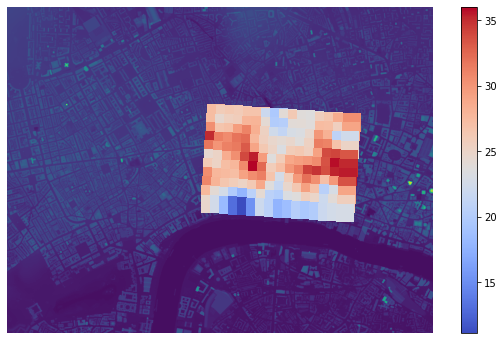

<AxesSubplot:>

In [51]:
drones_zonal_stats.set_geometry('buff').plot(
    column = 'mean', cmap = 'coolwarm', figsize = (10,6), legend = True).axis('off')
show(dsm_show)

## Print to .txt using specified columns

In [54]:
# sep = sets separator
# float_format sets numbers of decimals

# .to_csv('filename.txt', sep = 'separator of choice', float_format = '%.numberf')

drones_zonal_stats.set_index('id')[['mean','min','max']].to_csv('droneheight_jupyter.txt',
                                                                sep = '\t',float_format = '%.3f')

pd.read_csv('droneheight_jupyter.txt', sep = '\t', index_col = 'id')

,mean,min,max
id,,,
1,27.327,18.152,51.698
2,27.276,19.790,51.698
3,30.462,18.714,65.817
4,35.130,18.040,68.976
5,31.780,17.620,68.976
...,...,...,...
172,35.511,9.477,62.363
173,33.553,3.527,81.932
174,29.076,3.527,81.932


## Create a shapefile or other filetype from zonal statistics using geopandas

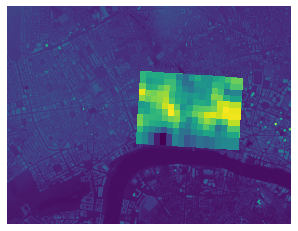

<AxesSubplot:>

In [56]:
gpd.GeoDataFrame(drones_zonal_stats[['mean','min','max','buff']], geometry='buff').to_file('drone_zonal_stats.shp')

gpd.read_file('drone_zonal_stats.shp').plot(column='mean').axis('off')
show(dsm_show)